# Malaysia COVID-19 Cases and Vaccination

Data taken from [**Malaysia's Ministry of Health**](https://github.com/MoH-Malaysia/covid19-public) and [**COVID-19 Immunisation Task Force (CITF)**](https://github.com/CITF-Malaysia/citf-public) as of **`6-10-2021`** (cut-off date).

1. [covid19-public](https://github.com/MoH-Malaysia/covid19-public/tree/9a8482527c486effa37900756631f843af4d6373)
2. [citf-public](https://github.com/CITF-Malaysia/citf-public/tree/46f91d6e18e38a24034bf8f791cd279b31f94f24)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import pickle

from imblearn.over_sampling import SMOTE
from collections import Counter

## 1. Loading Cleaned Datasets

Loading cleaned datasets that was pickled in `EDA_Epidemic.ipynb`, `EDA_Vaccination_&_Registration.ipynb`, and `EDA_MySejahtera.ipynb`

In [2]:
##### EPIDEMIC dataset #####
## Cases and Testing
cases_malaysia = pickle.load(open('pickle_files/cases_malaysia.pkl', 'rb'))
cases_malaysia_cluster = pickle.load(open('pickle_files/cases_malaysia_cluster.pkl', 'rb'))
cases_state = pickle.load(open('pickle_files/cases_state.pkl', 'rb')) 

tests_malaysia = pickle.load(open('pickle_files/tests_malaysia.pkl', 'rb')) 
tests_state = pickle.load(open('pickle_files/tests_state.pkl', 'rb')) 

## Deaths
deaths_malaysia = pickle.load(open('pickle_files/deaths_malaysia.pkl', 'rb'))
deaths_state = pickle.load(open('pickle_files/deaths_state.pkl', 'rb')) 

## Static Data
population = pd.read_csv('dataset/static/population_moh.csv')

##### VACCINATION & REGISTRATION dataset #####
## Adverse Events Following Immunization (AEFI)
aefi = pickle.load(open('pickle_files/aefi.pkl', 'rb'))
aefi_serious = pickle.load(open('pickle_files/aefi.pkl', 'rb'))

## Vaccination
vax_malaysia = pickle.load(open('pickle_files/vax_malaysia.pkl', 'rb'))
vax_state = pickle.load(open('pickle_files/vax_state.pkl', 'rb'))

## Registration
vaxreg_malaysia = pickle.load(open('pickle_files/vaxreg_malaysia.pkl', 'rb'))
vaxreg_state = pickle.load(open('pickle_files/vaxreg_state.pkl', 'rb'))

##### MYSEJAHTERA dataset #####
checkin_malaysia = pickle.load(open('pickle_files/checkin_malaysia.pkl', 'rb'))
checkin_malaysia_time = pickle.load(open('pickle_files/checkin_malaysia_time.pkl', 'rb'))
checkin_state = pickle.load(open('pickle_files/checkin_state.pkl', 'rb'))
trace_malaysia = pickle.load(open('pickle_files/trace_malaysia.pkl', 'rb'))

# 2. Questions
1. What are the cases, tests and deaths rate of each state in Malaysia? Do they correlate with each other? 
    - Can use histogram + line graph (not observing rate)
    - Bar/Pie? (to observe rate)
    - 16 states x 3 (cases, tests, deaths) x 2 (types of plots)
    
    
2. Cluster? Date start and date end
    - Cluster analysis (Lab10)
    
    
3. Which states are not doing well? (more cases and deaths)
    - Rank according states
    - Population / land area (need additional dataset)


4. Bed utilization rate


5. Analyse covid cases based on cases type in Malaysia
    - Cases
    - Vaccination Status
    - Age Group (0-11, 12-17, 18-59, >60)


6. EDA for covid cases based on state


## Final Selection
1. Analyse which group of population are more vulnerable to covid cases based on cases type in Malaysia
2. Analyse how covid cases vary across time dimension.
3. What is the stationrity of all test, deaths, checkin data.

# 3. EDA

### 3.1  Analyse which group of population are more vulnerable to covid cases based on cases type in Malaysia
Using [pandas.melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html)

In [3]:
cases_malaysia.tail(3)

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
617,2021-10-03,9066,12,14454,150146,388,1119,4941,1700,764,5348,1087
618,2021-10-04,8075,6,15456,142746,731,1093,4282,1353,641,5050,948
619,2021-10-05,8817,14,15615,135945,619,1060,5105,1386,686,5624,1007


In [4]:
cases_type = ['cases_new',\
              'cases_import',\
              'cases_recovered',\
              'cases_cluster',\
              'cases_pvax','cases_fvax',\
              'cases_child','cases_adolescent','cases_adult','cases_elderly']
cases_malaysia_melt = cases_malaysia[cases_type].melt()
cases_malaysia_melt.columns = ['cases_type', 'count'] # change column name
cases_malaysia_melt

,cases_type,count
0,cases_new,4
1,cases_new,0
2,cases_new,0
3,cases_new,0
4,cases_new,3
...,...,...
6195,cases_elderly,1277
6196,cases_elderly,1166
6197,cases_elderly,1087
6198,cases_elderly,948


In [5]:
# sns.set(rc={'figure.figsize':(11,6)})
# sns.set(style="whitegrid", color_codes=True)

# plot_cases_type = sns.swarmplot(x='cases_Type', y='count', data=cases_malaysia_melt)

# plot_cases_type.set_xticklabels(plot_cases_type.get_xticklabels(), rotation=90)
# plot_cases_type.set_title('Cases Type and Count')
# plot_cases_type.set_ylabel('Cases Type')
# plot_cases_type.set_xlabel('Count')

In [6]:
df_casesTotal = cases_malaysia_melt.groupby(["cases_type"]).sum() 
df_casesTotal.reset_index(inplace=True)
df_casesTotal

,cases_type,count
0,cases_adolescent,158432
1,cases_adult,1577927
2,cases_child,304128
3,cases_cluster,473962
4,cases_elderly,182713
5,cases_fvax,343027
6,cases_import,4915
7,cases_new,2294457
8,cases_pvax,373610
9,cases_recovered,2131636


In [7]:
def findCasesByOption(df_casesTotal, options):
    df_optionTotal = df_casesTotal.loc[df_casesTotal['cases_type'].isin(options)]
    df_optionTotal.sort_values('count', axis=0, inplace=True)
    return df_optionTotal

In [8]:
def plotCasesByOption(df_casesTotal, title='', x_label='', y_label='Number of Cases', ymax=2000000):
    sns.set(rc={'figure.figsize':(11,6)})
    sns.set(style="whitegrid", color_codes=True)

    b = sns.barplot(x="cases_type", y="count",  data=df_casesTotal)
    b.set_xticklabels(b.get_xticklabels(), rotation=90)
    b.set_title(title)
    b.set_ylabel(x_label)
    b.set_xlabel(y_label)
    b.set(ylim=(0, ymax))

    for p in b.patches:
            b.annotate("%.0f" % p.get_height(), (p.get_x() + 
        p.get_width() / 2., p.get_height()), 
            ha='center', va='center', rotation=0, 
        xytext=(0, 18), textcoords='offset points')

In [9]:
options = ['cases_child','cases_adolescent','cases_adult','cases_elderly']
df_casesAgeTotal = findCasesByOption(df_casesTotal, options)
df_casesAgeTotal

<ipython-input-7-e3fdf8520685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_optionTotal.sort_values('count', axis=0, inplace=True)


,cases_type,count
0,cases_adolescent,158432
4,cases_elderly,182713
2,cases_child,304128
1,cases_adult,1577927


In [10]:
ageVerifiedTotal = df_casesAgeTotal['count'].sum()
casesTotal = df_casesTotal[df_casesTotal['cases_type'] == 'cases_new']['count'].sum()
ageUnVerifiedTotal = casesTotal - ageVerifiedTotal
ageUnVerifiedTotal

71257

In [11]:
ageUnVerifiedDict = {'cases_type': 'cases_unverified_age', 'count': ageUnVerifiedTotal}
df_casesAgeTotal = df_casesAgeTotal.append(ageUnVerifiedDict, ignore_index = True,)
df_casesAgeTotal.sort_values('count', axis=0, inplace=True)
df_casesAgeTotal

,cases_type,count
4,cases_unverified_age,71257
0,cases_adolescent,158432
1,cases_elderly,182713
2,cases_child,304128
3,cases_adult,1577927


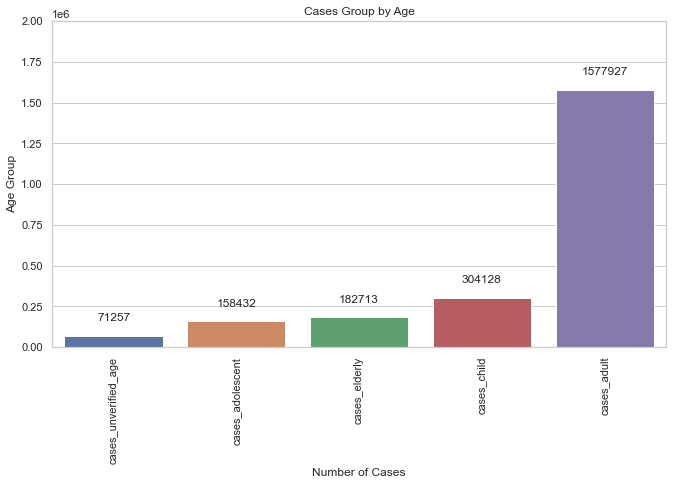

In [12]:
plotCasesByOption(df_casesAgeTotal, 'Cases Group by Age', 'Age Group', 'Number of Cases')

One key observation is that cases_child has more than 100k than other age limit accept cases_adult. The reason is unknown but we deduce that if the adult get covid cases, there's high chance that the child have to depends on adults

In [13]:
options = ['cases_pvax','cases_fvax']
df_casesGroupByVaccine = findCasesByOption(df_casesTotal, options)
df_casesGroupByVaccine

<ipython-input-7-e3fdf8520685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_optionTotal.sort_values('count', axis=0, inplace=True)


,cases_type,count
5,cases_fvax,343027
8,cases_pvax,373610


In [14]:
casesVaccinedTotal = df_casesGroupByVaccine['count'].sum()
casesTotal = df_casesTotal[df_casesTotal['cases_type'] == 'cases_new']['count'].sum()
casesUnvaccinatedTotal = casesTotal - casesVaccinedTotal
casesUnvaccinatedTotal

1577820

In [15]:
casesUnvaccinatedDict = {'cases_type': 'cases_unvaccinated', 'count': casesUnvaccinatedTotal}
df_casesGroupByVaccine = df_casesGroupByVaccine.append(casesUnvaccinatedDict, ignore_index = True,)
df_casesGroupByVaccine.sort_values('count', axis=0, inplace=True)
df_casesGroupByVaccine

,cases_type,count
0,cases_fvax,343027
1,cases_pvax,373610
2,cases_unvaccinated,1577820


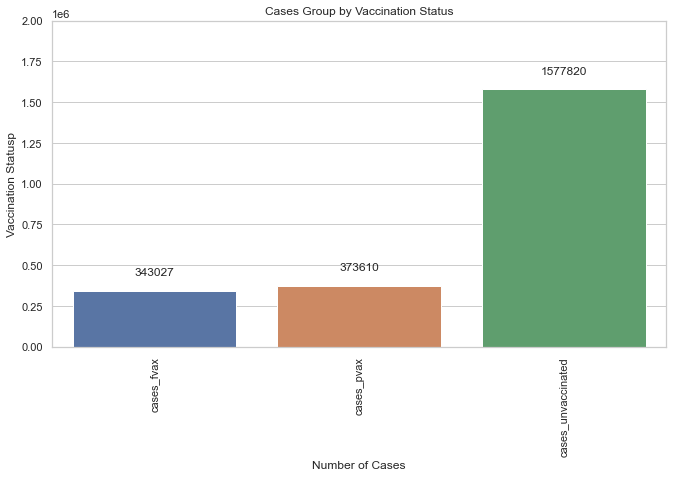

In [16]:
plotCasesByOption(df_casesGroupByVaccine, 'Cases Group by Vaccination Status', 'Vaccination Statusp')

#### 3.2 cases_malaysia_cluster

In [17]:
cases_malaysia_cluster.head(3)

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
342,2021-01-01,2068,2,2230,23382,944,0,0,121,76,1721,119,0.0,0.0,35.0,17.0,0.0,18.0,671.0
343,2021-01-02,2295,9,3321,22347,1091,0,0,116,61,1896,117,0.0,2.0,30.0,33.0,0.0,135.0,882.0
344,2021-01-03,1704,5,2726,21317,588,0,0,160,77,1307,118,0.0,0.0,41.0,25.0,0.0,83.0,432.0


In [18]:
cases_type2 = ['cases_new',\
              'cluster_import',\
              'cluster_religious',\
              'cluster_community',\
              'cluster_highRisk',\
              'cluster_education',\
              'cluster_detentionCentre',\
              'cluster_workplace']
cases_malaysia_cluster_melt = cases_malaysia_cluster[cases_type2].melt()
cases_malaysia_cluster_melt.columns = ['cases_type', 'count'] # change column name
cases_malaysia_cluster_melt

,cases_type,count
0,cases_new,2068.0
1,cases_new,2295.0
2,cases_new,1704.0
3,cases_new,1741.0
4,cases_new,2027.0
...,...,...
2219,cluster_workplace,393.0
2220,cluster_workplace,380.0
2221,cluster_workplace,140.0
2222,cluster_workplace,613.0


In [19]:
df_casesClusterTotal = cases_malaysia_cluster_melt.groupby(["cases_type"]).sum() 
df_casesClusterTotal.sort_values('count', axis=0, inplace=True)
df_casesClusterTotal.reset_index(inplace=True)
df_casesClusterTotal

,cases_type,count
0,cluster_import,131.0
1,cluster_religious,8194.0
2,cluster_highRisk,8494.0
3,cluster_education,10851.0
4,cluster_detentionCentre,21832.0
5,cluster_community,69732.0
6,cluster_workplace,219381.0
7,cases_new,2181447.0


In [20]:
def getUncategorized(df, overall_column='', new_column_name=''):
    partial_sum = df[df['cases_type'] != overall_column]['count'].sum()
    overall_sum = df[df['cases_type'] == overall_column]['count'].sum()
    uncategorized_subset = overall_sum - partial_sum

    tempDict = {'cases_type': new_column_name, 'count': uncategorized_subset}
    df = df.append(tempDict, ignore_index = True,)
    df.sort_values('count', axis=0, inplace=True)
    return df

In [21]:
clusterTotal = getUncategorized(df_casesClusterTotal, 'cases_new', 'cluster_not_found')
clusterTotal = clusterTotal[clusterTotal['cases_type'] != 'cases_new']
clusterTotal

,cases_type,count
0,cluster_import,131.0
1,cluster_religious,8194.0
2,cluster_highRisk,8494.0
3,cluster_education,10851.0
4,cluster_detentionCentre,21832.0
5,cluster_community,69732.0
6,cluster_workplace,219381.0
8,cluster_not_found,1842832.0


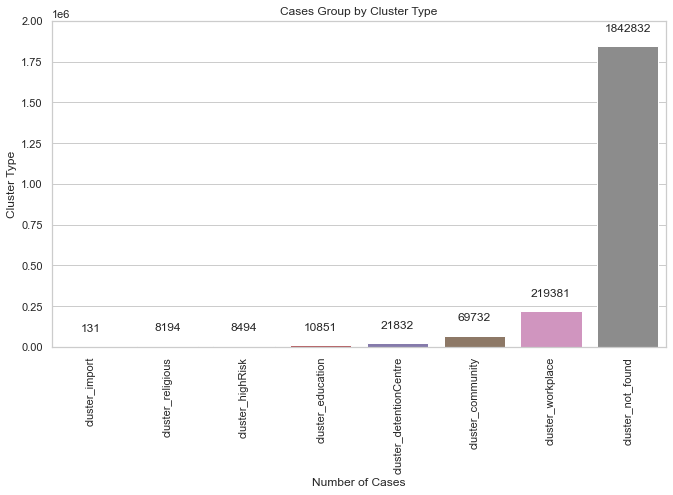

In [22]:
plotCasesByOption(clusterTotal, 'Cases Group by Cluster Type', 'Cluster Type', 'Number of Cases', 2000000)

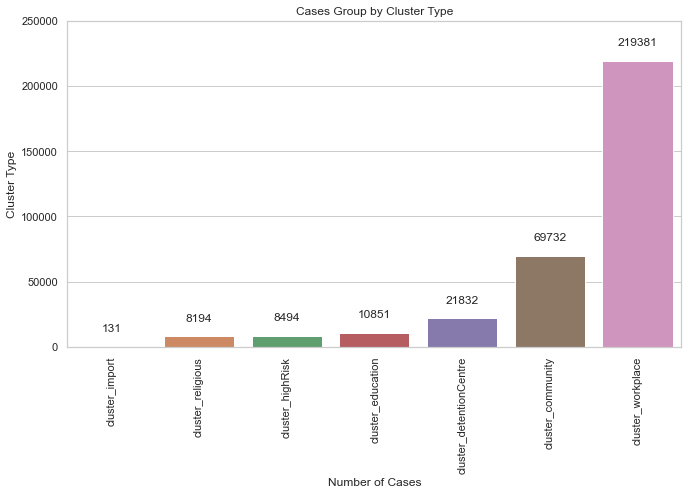

In [23]:
clusterTotal = clusterTotal[clusterTotal['cases_type'] != 'cluster_not_found']
plotCasesByOption(clusterTotal, 'Cases Group by Cluster Type', 'Cluster Type', 'Number of Cases', 250000)

In [24]:
options = ['cases_new','cases_import']
df_casesImportTotal = findCasesByOption(df_casesTotal, options)
df_casesImportTotal

<ipython-input-7-e3fdf8520685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_optionTotal.sort_values('count', axis=0, inplace=True)


,cases_type,count
6,cases_import,4915
7,cases_new,2294457


### 3.3 cases_state

In [25]:
cases_state.head(3)

,date,state,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,Johor,4,4,0,4,0,0,0,0,0,1,0
1,2020-01-25,Kedah,0,0,0,0,0,0,0,0,0,0,0
2,2020-01-25,Kelantan,0,0,0,0,0,0,0,0,0,0,0


In [26]:
tests_state.head(3)

,date,state,rtk-ag,pcr
0,2021-07-01,Johor,2749,3670
1,2021-07-01,Kedah,2073,1297
2,2021-07-01,Kelantan,1348,1966


In [27]:
deaths_state.head(3)

,date,state,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,Johor,1,0,1,0,0,0,0
1,2020-03-17,Kedah,0,0,0,0,0,0,0
2,2020-03-17,Kelantan,0,0,0,0,0,0,0


In [28]:
checkin_state.head(3)

,date,state,checkins,unique_ind,unique_loc
0,2020-12-01,Johor,1996696,868521,81635
1,2020-12-01,Kedah,654634,341620,32760
2,2020-12-01,Kelantan,186507,108035,16298


### 3.2  Analyse how covid cases vary across time dimension.

In [29]:
import datetime 

# Year, full version
def strftime_year(date):
    return date.strftime("%Y")

# Month as a number 01-12
def strftime_monthNumber(date):
    return date.strftime("%m")

# Week number of year, Sunday as the first day of week, 00-53
def strftime_weekNumber(date):
    return date.strftime("%W")

# Day number of year 001-366
def strftime_dayNumber(date):
    return date.strftime("%j")

#Weekday as a number 0-6, 0 is Sunday
def strftime_weekdayNumber(date):
    return date.strftime("%w")

# Weekday, full version
def strftime_weekdayName(date):
    return date.strftime("%A")

# shortcut for strftime a dataframe
def strftime_all(df):
    df_dt = df.copy()
    df_dt['year'] = df['date'].apply(strftime_year)
    df_dt['month_number'] = df_dt['date'].apply(strftime_monthNumber)
    df_dt['week_number'] = df_dt['date'].apply(strftime_weekNumber)
    df_dt['day_number'] = df_dt['date'].apply(strftime_dayNumber)
    df_dt['weekday_number'] = df_dt['date'].apply(strftime_weekdayNumber)
    df_dt['weekday_name'] = df_dt['date'].apply(strftime_weekdayName)
    return df_dt

In [30]:
df_cases_dateDim = cases_malaysia.copy()
df_cases_dateDim['date'] = df_cases_dateDim['date'].astype('datetime64[ns]')
df_cases_dateDim = strftime_all(df_cases_dateDim)
df_cases_dateDim

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,year,month_number,week_number,day_number,weekday_number,weekday_name
0,2020-01-25,4,4,0,4,0,0,0,0,0,1,0,2020,01,03,025,6,Saturday
1,2020-01-26,0,0,0,4,0,0,0,0,0,0,0,2020,01,03,026,0,Sunday
2,2020-01-27,0,0,0,4,0,0,0,0,0,0,0,2020,01,04,027,1,Monday
3,2020-01-28,0,0,0,4,0,0,0,0,0,0,0,2020,01,04,028,2,Tuesday
4,2020-01-29,3,3,0,7,0,0,0,1,0,2,0,2020,01,04,029,3,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,2021-10-01,11889,14,15891,160144,868,1475,6577,2081,921,7473,1277,2021,10,39,274,5,Friday
616,2021-10-02,10915,7,15396,155578,656,1303,5882,1951,938,6756,1166,2021,10,39,275,6,Saturday
617,2021-10-03,9066,12,14454,150146,388,1119,4941,1700,764,5348,1087,2021,10,39,276,0,Sunday
618,2021-10-04,8075,6,15456,142746,731,1093,4282,1353,641,5050,948,2021,10,40,277,1,Monday


In [31]:
# drop last 2 rows because week 3 is not complete
df_cases_dateDim_drillDownWeek = df_cases_dateDim.drop(df_cases_dateDim.tail(2).index)

# drop first 2 rows because week 40 is not complete
df_cases_dateDim_drillDownWeek.drop(df_cases_dateDim_drillDownWeek.head(2).index,inplace=True)
df_cases_dateDim_drillDownWeek

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,year,month_number,week_number,day_number,weekday_number,weekday_name
2,2020-01-27,0,0,0,4,0,0,0,0,0,0,0,2020,01,04,027,1,Monday
3,2020-01-28,0,0,0,4,0,0,0,0,0,0,0,2020,01,04,028,2,Tuesday
4,2020-01-29,3,3,0,7,0,0,0,1,0,2,0,2020,01,04,029,3,Wednesday
5,2020-01-30,1,1,0,8,0,0,0,0,0,1,0,2020,01,04,030,4,Thursday
6,2020-01-31,0,0,0,8,0,0,0,0,0,0,0,2020,01,04,031,5,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,2021-09-29,12434,8,17000,169336,710,1642,6732,1950,960,7990,1386,2021,09,39,272,3,Wednesday
614,2021-09-30,12735,17,17725,164230,764,1674,6836,2242,1115,7935,1281,2021,09,39,273,4,Thursday
615,2021-10-01,11889,14,15891,160144,868,1475,6577,2081,921,7473,1277,2021,10,39,274,5,Friday
616,2021-10-02,10915,7,15396,155578,656,1303,5882,1951,938,6756,1166,2021,10,39,275,6,Saturday


<AxesSubplot:title={'center':'2020'}, xlabel='Week', ylabel='Count'>

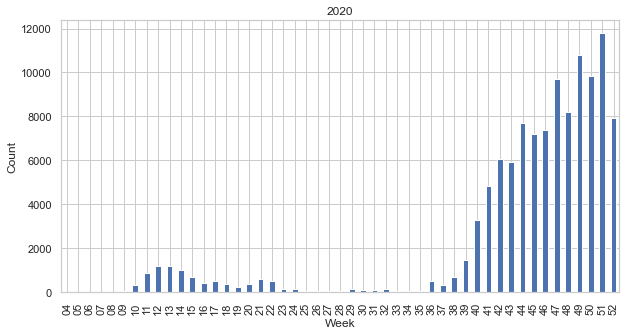

In [32]:
df_cases_dateDim_2020 = df_cases_dateDim_drillDownWeek[df_cases_dateDim_drillDownWeek['year']=='2020']
df_cases_dateDim_2020 = df_cases_dateDim_2020.groupby(['week_number'])['cases_new'].sum()

df_cases_dateDim_2020.plot(kind='bar', title='2020', ylabel='Count', xlabel='Week', figsize=(10, 5))

<AxesSubplot:title={'center':'2021'}, xlabel='Week', ylabel='Count'>

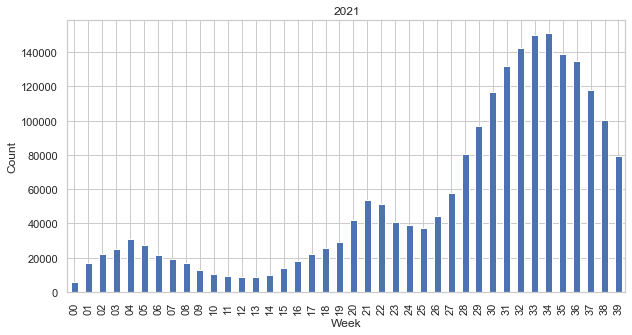

In [33]:
df_cases_dateDim_2021 = df_cases_dateDim_drillDownWeek[df_cases_dateDim_drillDownWeek['year']=='2021']
df_cases_dateDim_2021 = df_cases_dateDim_2021.groupby(['week_number'])['cases_new'].sum()

df_cases_dateDim_2021.plot(kind='bar', title='2021', ylabel='Count', xlabel='Week', figsize=(10, 5))

<AxesSubplot:xlabel='Day', ylabel='Count'>

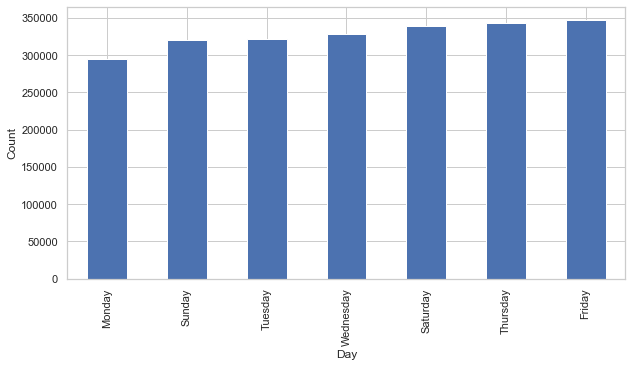

In [34]:
df_cases_dateDim_weekday = df_cases_dateDim.groupby(['weekday_name'])['cases_new'].sum()
df_cases_dateDim_weekday.sort_values(inplace=True)

df_cases_dateDim_weekday.plot(kind='bar', title='', ylabel='Count', xlabel='Day', figsize=(10, 5))

<AxesSubplot:title={'center':'2020'}, xlabel='Month', ylabel='Count'>

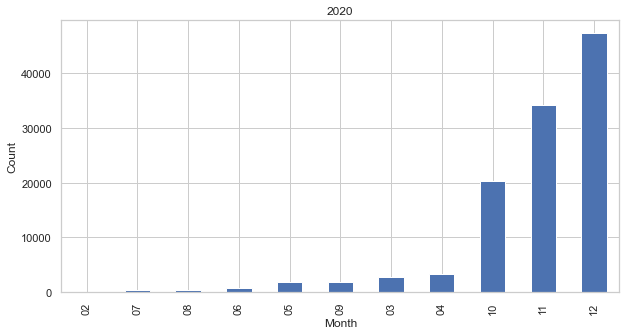

In [35]:
df_cases_dateDim_2020 = df_cases_dateDim[df_cases_dateDim['year']=='2020']
df_cases_dateDim_2020 = df_cases_dateDim_2020[df_cases_dateDim_2020['month_number']!='01']
df_cases_dateDim_2020 = df_cases_dateDim_2020.groupby(['month_number'])['cases_new'].sum()
df_cases_dateDim_2020.sort_values(inplace=True)

df_cases_dateDim_2020.plot(kind='bar', title='2020', ylabel='Count', xlabel='Month', figsize=(10, 5))

<AxesSubplot:title={'center':'2021'}, xlabel='Month', ylabel='Count'>

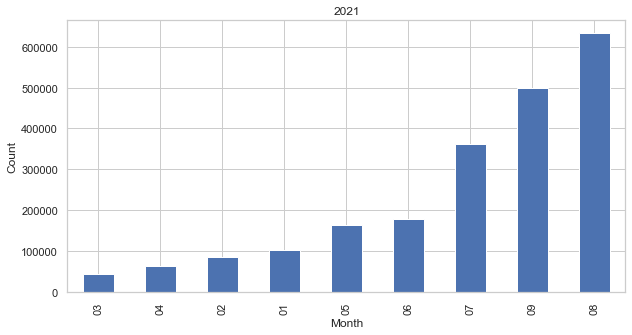

In [36]:
df_cases_dateDim_2021 = df_cases_dateDim[df_cases_dateDim['year']=='2021']
df_cases_dateDim_2021 = df_cases_dateDim_2021[df_cases_dateDim_2021['month_number']!='10']
df_cases_dateDim_2021 = df_cases_dateDim_2021.groupby(['month_number'])['cases_new'].sum()
df_cases_dateDim_2021.sort_values(inplace=True)

df_cases_dateDim_2021.plot(kind='bar', title='2021', ylabel='Count', xlabel='Month', figsize=(10, 5))

### Time Series Analysis

Watch this moving average and window rolling tutorials
<br>
youtube https://www.youtube.com/watch?v=T2mQiesnx8s
<br>
Source code https://nbviewer.org/urls/alphabench.com/data/pandas_rolling_method.ipynb

In [37]:
# malaysia cases
df_cases_my = cases_malaysia[['date','cases_new','cases_recovered','cases_active']]
df_cases_my

,date,cases_new,cases_recovered,cases_active
0,2020-01-25,4,0,4
1,2020-01-26,0,0,4
2,2020-01-27,0,0,4
3,2020-01-28,0,0,4
4,2020-01-29,3,0,7
...,...,...,...,...
615,2021-10-01,11889,15891,160144
616,2021-10-02,10915,15396,155578
617,2021-10-03,9066,14454,150146
618,2021-10-04,8075,15456,142746


In [38]:
df_ma = df_cases_my.copy()
df_ma['MA_3'] = df_ma.cases_new.rolling(3).mean()#.shift() # shift it to next day for forecasting purpose
df_ma['MA_5'] = df_ma.cases_new.rolling(5).mean()
df_ma['MA_7'] = df_ma.cases_new.rolling(7).mean()
df_ma['STD_7'] = df_ma.cases_new.rolling(7).std()

df_ma

,date,cases_new,cases_recovered,cases_active,MA_3,MA_5,MA_7,STD_7
0,2020-01-25,4,0,4,NaN,NaN,NaN,NaN
1,2020-01-26,0,0,4,NaN,NaN,NaN,NaN
2,2020-01-27,0,0,4,1.333333,NaN,NaN,NaN
3,2020-01-28,0,0,4,0.000000,NaN,NaN,NaN
4,2020-01-29,3,0,7,1.000000,1.4,NaN,NaN
...,...,...,...,...,...,...,...,...
615,2021-10-01,11889,15891,160144,12352.666667,11869.8,12336.000000,1025.146494
616,2021-10-02,10915,15396,155578,11846.333333,11861.0,11909.714286,876.526043
617,2021-10-03,9066,14454,150146,10623.333333,11407.8,11332.857143,1220.712282
618,2021-10-04,8075,15456,142746,9352.000000,10536.0,10920.857143,1742.913598


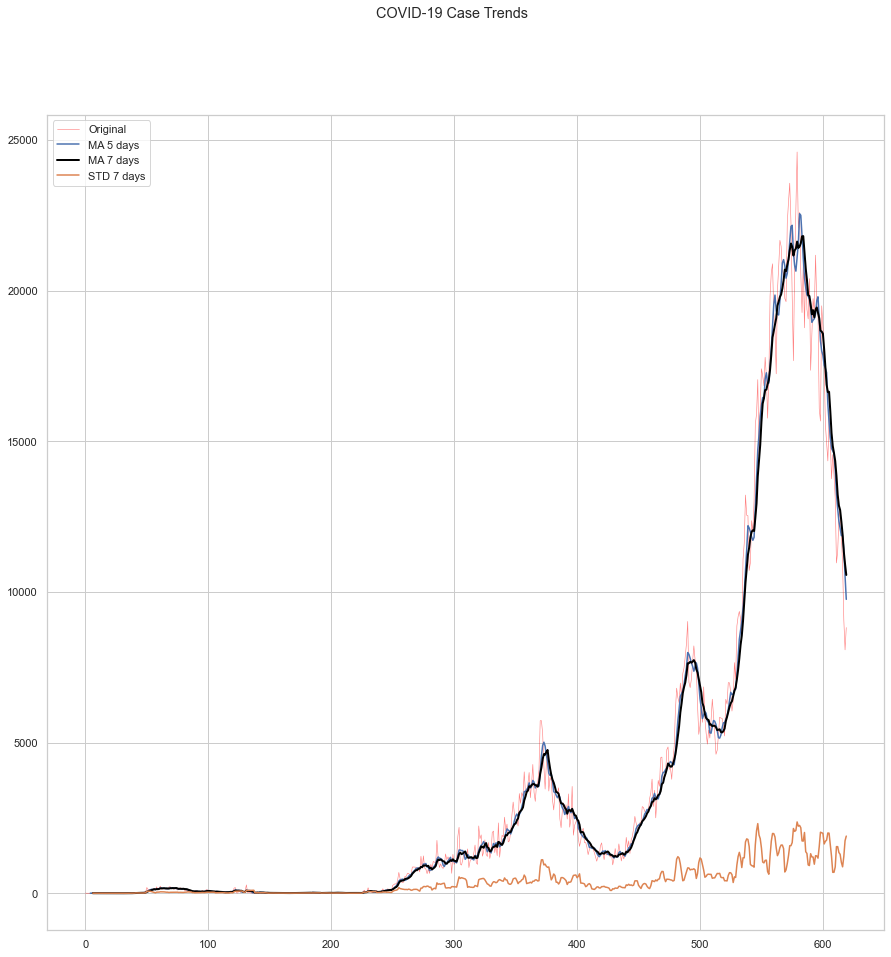

In [39]:
plt.figure(figsize=(15,15))
plt.grid(True)
plt.suptitle('COVID-19 Case Trends')
plt.plot(df_ma['cases_new'], label='Original', color='red', linewidth =0.6, alpha = 0.5)
plt.plot(df_ma['MA_5'], label='MA 5 days')
plt.plot(df_ma['MA_7'], label='MA 7 days', color='black', linewidth =2)
plt.plot(df_ma['STD_7'], label='STD 7 days')
plt.legend(loc=2)

In [40]:
# plt.figure(figsize=(15, 5))
# plt.suptitle('COVID-19 Case Trends')

# temp['cases_new'].plot(legend=None, color='red', label="cases new", linewidth =0.8, alpha = 0.5)
# temp['cases_new_norm_ma'].plot(legend=None, color='black', label="cases new mov avg")

# plt.legend()

In [41]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, df, windowNumber=12):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=windowNumber).mean()
    movingSTD = timeseries.rolling(window=windowNumber).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries.iloc[:,1:], color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # perfrom dickey fuller test:
    print('Reuslts of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC') #AIC is a matrix
    dfoutput = pd.Series(dftest[:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)
    # p-value should be less
    # critical value > test statistic

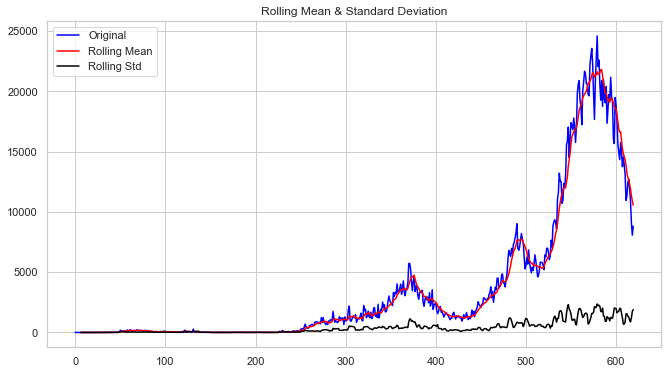

Reuslts of Dickey-Fuller Test:
Test Statistic                  -2.878612
p-value                          0.047892
#Lags Used                      19.000000
Number of Observations Used    600.000000
Critical Value (1%)             -3.441296
Critical Value (5%)             -2.866369
Critical Value (10%)            -2.569342
dtype: float64


In [42]:
test_stationarity(df_ma[['date','cases_new']], df_ma['cases_new'], 7)

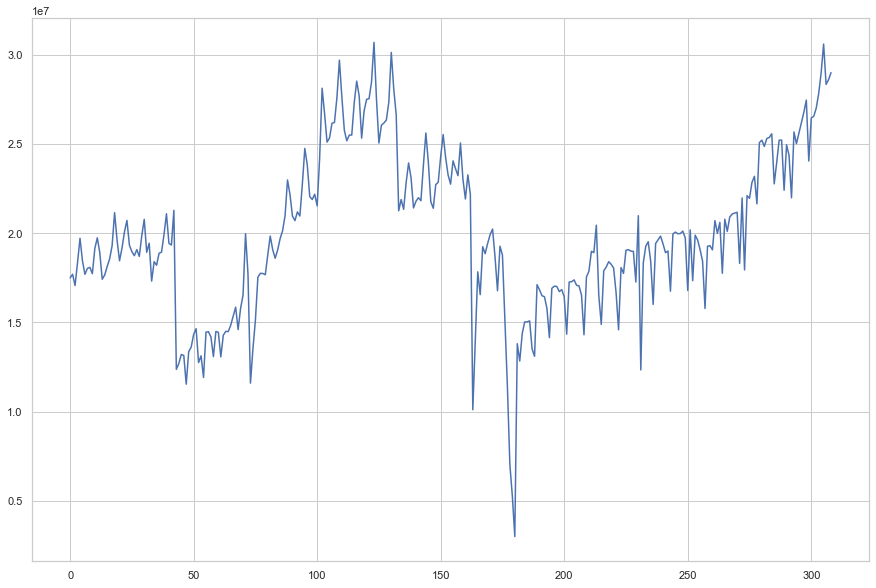

In [43]:
df_checkins = checkin_malaysia[['date','checkins']]
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_checkins['checkins'],label='Cases New')
plt.show()

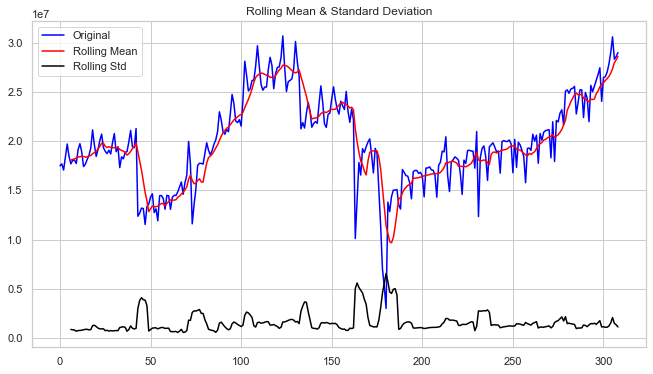

Reuslts of Dickey-Fuller Test:
Test Statistic                  -1.134774
p-value                          0.701007
#Lags Used                      14.000000
Number of Observations Used    294.000000
Critical Value (1%)             -3.452790
Critical Value (5%)             -2.871422
Critical Value (10%)            -2.572035
dtype: float64


In [44]:
test_stationarity(df_checkins[['date','checkins']], df_checkins['checkins'], 7)

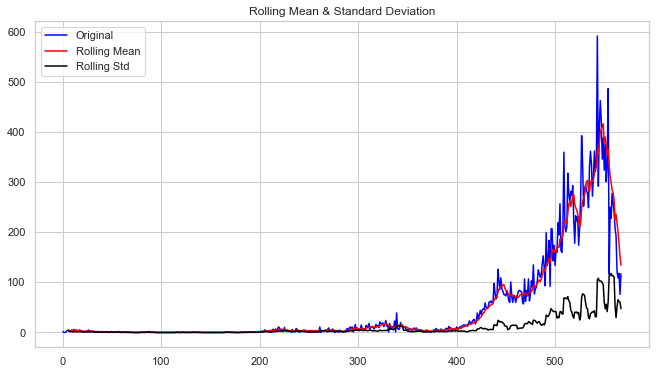

Reuslts of Dickey-Fuller Test:
Test Statistic                  -3.412172
p-value                          0.010551
#Lags Used                      19.000000
Number of Observations Used    548.000000
Critical Value (1%)             -3.442339
Critical Value (5%)             -2.866829
Critical Value (10%)            -2.569587
dtype: float64


In [45]:
test_stationarity(deaths_malaysia[['date','deaths_new']], deaths_malaysia['deaths_new'], 7)

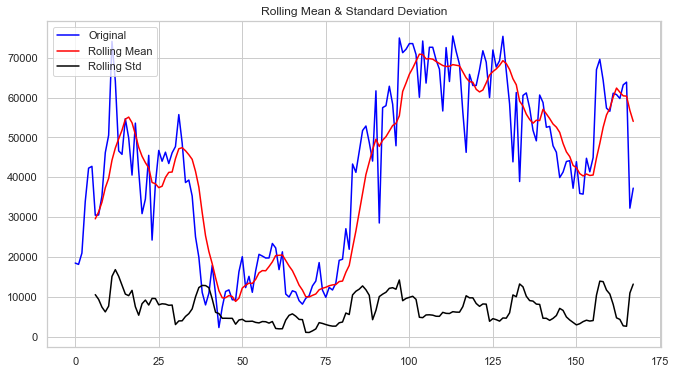

Reuslts of Dickey-Fuller Test:
Test Statistic                  -2.089453
p-value                          0.248777
#Lags Used                       7.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


In [48]:
test_stationarity(trace_malaysia[['date','casual_contacts']], trace_malaysia['casual_contacts'], 7)

This dataset is non-stationary as it has moving mean and variance

#### Time Series and Statsmodels

[Stationairty](https://www.youtube.com/watch?v=oY-j2Wof51c)
<br>
Stationarity determine what predictive models you could use. The data is stationary if
<br>
- Mean is const
- Variance is const (less fluctuation)
- No seasonality
<br>
White noise also means it is stationary, but if it's stationary it not neccessary is white noise.

[statsmodels.tsa.stattools.adfuller](https://docs.w3cub.com/statsmodels/generated/statsmodels.tsa.stattools.adfuller)

[Revision about test statistic, p-value and critical value](https://towardsdatascience.com/statistical-tests-when-to-use-which-704557554740#:~:text=Relationship%20between%20p%2Dvalue%2C%20critical,Z%2C%20T%20or%20chi)